<a href="https://colab.research.google.com/github/dksifoua/Question-Answering/blob/master/1%20-%20DrQA%2C%20Document%20reader%20Question%20Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Nov  1 00:16:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load dependencies

In [2]:
!pip install tqdm --upgrade >> /dev/null 2>&1
!pip install spacy --upgrade >> /dev/null 2>&1
!python -m spacy download en >> /dev/null 2>&1

In [317]:
import re
import json
import time
import tqdm
import spacy
import string
import collections
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader

In [318]:
SEED = 546
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


## Prepare data

***Download data***

In [6]:
!rm -rf ./data
!mkdir ./data

!wget --no-check-certificate \
    https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json \
    -O ./data/train-v1.1.json

!wget --no-check-certificate \
    https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json \
    -O ./data/dev-v1.1.json

--2020-11-01 00:18:50--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [application/json]
Saving to: ‘./data/train-v1.1.json’

./data/train-v1.1.j 100%[===================>]  28.88M  73.3MB/s    in 0.4s    

2020-11-01 00:18:52 (73.3 MB/s) - ‘./data/train-v1.1.json’ saved [30288272/30288272]

--2020-11-01 00:18:52--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4854279 (4.6M) [application/json]
Saving to: ‘./data/dev-v1.1.json’


***Load JSON data***

In [7]:
def load(path):
    with open(path, mode='r', encoding='utf-8') as file:
        return json.load(file)['data']
    raise FileNotFoundError

In [8]:
train_raw_data = load('./data/train-v1.1.json')
valid_raw_data = load('./data/dev-v1.1.json')
print(f'Length of raw train data: {len(train_raw_data):,}')
print(f'Length of raw valid data: {len(valid_raw_data):,}')

Length of raw train data: 442
Length of raw valid data: 48


***Parse JSON data***

In [9]:
def parse(data, nlp=spacy.load('en')):
    qas = []
    for paragraphs in tqdm.tqdm(data):
        for para in paragraphs['paragraphs']:
            context = nlp(para['context'], disable=['parser'])
            for qa in para['qas']:
                id = qa['id']
                question = nlp(qa['question'], disable=['parser', 'tagger', 'ner'])
                for ans in qa['answers']:
                    qas.append({
                        'id': id,
                        'context': context,
                        'question': question,
                        'answer': nlp(ans['text'], disable=['parser', 'tagger', 'ner']),
                        'answer_start': ans['answer_start'],
                    })
    return qas

In [10]:
train_qas = parse(train_raw_data)
valid_qas = parse(valid_raw_data)
print()
print(f'Length of train qa pairs: {len(train_qas):,}')
print(f'Length of valid qa pairs: {len(valid_qas):,}')
print('==================== Example ====================')
print('Id:', train_qas[0]['id'])
print('Context:', train_qas[0]['context'])
print('Question:', train_qas[0]['question'])
print('Answer starts at:', train_qas[0]['answer_start'])
print('Answer:', train_qas[0]['answer'])

100%|██████████| 48/48 [00:34<00:00,  1.41it/s]


Length of train qa pairs: 87,599
Length of valid qa pairs: 34,726
==================== Example ====================
Id: 5733be284776f41900661182
Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer starts at: 515
Answer: Saint Bernadette Soubirous


In [11]:
def test_answer_start(qas):
    """Test answer_start are correct in train set"""
    for qa in tqdm.tqdm(qas):
        answer = qa['answer'].text
        context = qa['context'].text
        answer_start = qa['answer_start']
        assert answer == context[answer_start:answer_start + len(answer)]

In [12]:
test_answer_start(train_qas)
test_answer_start(valid_qas)

100%|██████████| 34726/34726 [00:03<00:00, 11420.74it/s]


***Add targets***

In [13]:
def add_targets(qas):
    """Add start and end index token"""
    for qa in qas:
        context = qa['context']
        answer = qa['answer']
        ans_start = qa['answer_start']
        for i in range(len(context)):
            if context[i].idx == ans_start:
                ans = context[i:i + len(answer)]
                qa['target'] = [ans[0].i, ans[-1].i]
                break

In [14]:
%%time
add_targets(train_qas)
add_targets(valid_qas)
print(f'Length of train qa pairs: {len(train_qas):,}')
print(f'Length of valid qa pairs: {len(valid_qas):,}')

Length of train qa pairs: 87,599
Length of valid qa pairs: 34,726
CPU times: user 1.52 s, sys: 16 ms, total: 1.53 s
Wall time: 1.54 s


In [15]:
def filter_qas(qa):
    """Remove bad targets"""
    if 'target' in [*qa.keys()]:
        start, end = qa['target']
        return qa['context'][start:end + 1].text == qa['answer'].text
    return False

In [16]:
%%time
train_qas = [*filter(filter_qas, train_qas)]
valid_qas = [*filter(filter_qas, valid_qas)]
print(f'Length of train qa pairs after filtering out bad qa pairs: {len(train_qas):,}')
print(f'Length of valid qa pairs after filtering out bad qa pairs: {len(valid_qas):,}')

Length of train qa pairs after filtering out bad qa pairs: 86,597
Length of valid qa pairs after filtering out bad qa pairs: 34,295
CPU times: user 1.15 s, sys: 4.99 ms, total: 1.16 s
Wall time: 1.16 s


In [17]:
def test_targets(qas):
    for qa in qas:
        if 'target' in [*qa.keys()]:
            start, end = qa['target']
            assert qa['context'][start:end + 1].text == qa['answer'].text

In [18]:
%%time
test_targets(train_qas)
test_targets(valid_qas)

CPU times: user 1.12 s, sys: 980 µs, total: 1.12 s
Wall time: 1.13 s


***Add features***

In [19]:
def add_features(qas):
    """Add extra features: Exact Match, Part-of-Speech, Name Entity Recognition & Normalized Term Frequency"""
    for qa in tqdm.tqdm(qas):
        question = [token.text.lower() for token in qa['question']]
        context = qa['context']
        counts = collections.Counter(map(lambda token: token.text.lower(), context))
        freqs = {index: counts[token.text.lower()] for index, token in enumerate(context)}
        freqs_norm = sum(freqs.values())
        qa['em'], qa['pos'], qa['ner'], qa['ntf'] = zip(
            *map(lambda index: [
                context[index].text.lower() in question, context[index].tag_,
                context[index].ent_type_ or 'None',
                freqs[index] / freqs_norm
            ], range(len(context)))
        )

In [20]:
add_features(train_qas)
add_features(valid_qas)

100%|██████████| 34295/34295 [00:21<00:00, 1624.91it/s]


***Build vocabularies***

In [173]:
class Vocab:

    def __init__(self, pad_token, unk_token):
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.vocab = None
        self.word2count = None
        self.word2index = None
        self.index2word = None
    
    def build(self, data, min_freq):
        """
        :param List[Union[spacy.tokens.doc.Doc, str, Tuple]] data
        :param int min_freq
        """
        words = [self.pad_token, self.unk_token]
        type_0 = type(data[0])
        if type_0 == spacy.tokens.doc.Doc:
            for item in data: # context and question
                words += [word.text.lower() for word in item]
        elif type_0 == str: # id
            words += data
        elif type_0 == tuple: # pos and ner
            for item in data:
                words += [word.lower() for word in item]
        self.word2count = collections.Counter(words)
        self.vocab = sorted(filter(
            lambda word: self.word2count[word] >= min_freq or word == self.pad_token or word == self.unk_token, self.word2count
        ))
        self.word2index = {word: index for index, word in enumerate(self.vocab)}
        self.index2word = {index: word for index, word in enumerate(self.vocab)}
    
    def __len__(self):
        return len(self.vocab)
    
    def stoi(self, word):
        return self.word2index.get(str(word), self.word2index[self.unk_token])

    def itos(self, index):
        return self.index2word[index]

In [174]:
%%time
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'

ID = Vocab(pad_token=PAD_TOKEN, unk_token=UNK_TOKEN)
POS = Vocab(pad_token=PAD_TOKEN, unk_token=UNK_TOKEN)
NER = Vocab(pad_token=PAD_TOKEN, unk_token=UNK_TOKEN)
TEXT = Vocab(pad_token=PAD_TOKEN, unk_token=UNK_TOKEN)

ids = [*map(lambda qa: qa['id'], train_qas)] + [*map(lambda qa: qa['id'], valid_qas)]
pos, ner, contexts, questions = zip(*map(lambda qa: (qa['pos'], qa['ner'], qa['context'], qa['question']), train_qas))

ID.build(data=[*set(ids)], min_freq=0)
POS.build(data=[*set(pos)], min_freq=0)
NER.build(data=[*set(ner)], min_freq=0)
TEXT.build(data=[*set(contexts)] + [*set(questions)], min_freq=5)

print(f'Length of ID vocabulary: {len(ID):,}')
print(f'Length of POS vocabulary: {len(POS):,}')
print(f'Length of NER vocabulary: {len(NER):,}')
print(f'Length of TEXT vocabulary: {len(TEXT):,}')

Length of ID vocabulary: 97,108
Length of POS vocabulary: 52
Length of NER vocabulary: 21
Length of TEXT vocabulary: 26,885
CPU times: user 5.61 s, sys: 12.6 ms, total: 5.63 s
Wall time: 5.63 s


***Build datasets***

In [175]:
class SQuADV1Dataset(Dataset):

    def __init__(self, data, id_vocab, pos_vocab, ner_vocab, text_vocab):
        self.data = data
        self.id_vocab = id_vocab
        self.pos_vocab = pos_vocab
        self.ner_vocab = ner_vocab
        self.text_vocab = text_vocab
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        id = torch.LongTensor([self.id_vocab.stoi(item['id'])])
        ctx = torch.LongTensor([*map(lambda token: self.text_vocab.stoi(token.text.lower()), item['context'])])
        qst = torch.LongTensor([*map(lambda token: self.text_vocab.stoi(token.text.lower()), item['question'])])
        trg = torch.LongTensor(item['target'])
        em = torch.LongTensor(item['em'])
        pos = torch.LongTensor([*map(lambda token: self.pos_vocab.stoi(token.lower()), item['pos'])])
        ner = torch.LongTensor([*map(lambda token: self.ner_vocab.stoi(token.lower()), item['ner'])])
        ntf = torch.FloatTensor(item['ntf'])
        return id, ctx, qst, trg, em, pos, ner, ntf

In [176]:
train_dataset = SQuADV1Dataset(data=train_qas, id_vocab=ID, pos_vocab=POS, ner_vocab=NER, text_vocab=TEXT)
valid_dataset = SQuADV1Dataset(data=valid_qas, id_vocab=ID, pos_vocab=POS, ner_vocab=NER, text_vocab=TEXT)

id, ctx, qst, trg, em, pos, ner, ntf = train_dataset[0]
print(f'id shape: {id.shape}')
print(f'ctx shape: {ctx.shape}')
print(f'qst shape: {qst.shape}')
print(f'trg shape: {trg.shape}')
print(f'em shape: {em.shape}')
print(f'pos shape: {pos.shape}')
print(f'ner shape: {ner.shape}')
print(f'ntf shape: {ntf.shape}')

id shape: torch.Size([1])
ctx shape: torch.Size([142])
qst shape: torch.Size([14])
trg shape: torch.Size([2])
em shape: torch.Size([142])
pos shape: torch.Size([142])
ner shape: torch.Size([142])
ntf shape: torch.Size([142])


***Build data loaders***

In [177]:
class DotDict(dict):
    __getattr__ = dict.get

In [178]:
def add_padding(batch, pad_token=PAD_TOKEN, text_vocab=TEXT, pos_vocab=POS, ner_vocab=NER, include_lengths=True, device=DEVICE):
    """Pad batch of sequence with different lengths"""
    batch_id, batch_ctx, batch_qst, batch_trg, batch_em, batch_pos, batch_ner, batch_ntf = zip(*batch)
    if include_lengths:
        len_ctx = torch.LongTensor([ctx.size(0) for ctx in batch_ctx]).to(device)
        len_qst = torch.LongTensor([qst.size(0) for qst in batch_qst]).to(device)
    batch_padded_id = pad_sequence(batch_id, batch_first=True).to(device)
    batch_padded_ctx = pad_sequence(batch_ctx, batch_first=True, padding_value=text_vocab.stoi(pad_token)).to(device)
    batch_padded_qst = pad_sequence(batch_qst, batch_first=True, padding_value=text_vocab.stoi(pad_token)).to(device)
    batch_padded_trg = pad_sequence(batch_trg, batch_first=True).to(device)
    batch_padded_em = pad_sequence(batch_em, batch_first=True).to(device)
    batch_padded_pos = pad_sequence(batch_pos, batch_first=True, padding_value=pos_vocab.stoi(pad_token)).to(device)
    batch_padded_ner = pad_sequence(batch_ner, batch_first=True, padding_value=ner_vocab.stoi(pad_token)).to(device)
    batch_padded_ntf = pad_sequence(batch_ntf, batch_first=True).to(device)
    return DotDict({
        'id': batch_padded_id,
        'ctx': (batch_padded_ctx, len_ctx) if include_lengths else batch_padded_ctx,
        'qst': (batch_padded_qst, len_qst) if include_lengths else batch_padded_qst,
        'trg': batch_padded_trg,
        'em': batch_padded_em,
        'pos': batch_padded_pos,
        'ner': batch_padded_ner,
        'ntf': batch_padded_ntf,
    })

In [179]:
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=add_padding)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=add_padding)

for batch in train_dataloader:
    print('batch.id shape:', batch.id.shape)
    print('batch.ctx shape:', batch.ctx[0].shape, batch.ctx[1].shape)
    print('batch.qst shape:', batch.qst[0].shape, batch.qst[1].shape)
    print('batch.trg shape:', batch.trg.shape)
    print('batch.em shape:', batch.em.shape)
    print('batch.pos shape:', batch.pos.shape)
    print('batch.ner shape:', batch.ner.shape)
    print('batch.ntf shape:', batch.ntf.shape)
    break

batch.id shape: torch.Size([64, 1])
batch.ctx shape: torch.Size([64, 253]) torch.Size([64])
batch.qst shape: torch.Size([64, 19]) torch.Size([64])
batch.trg shape: torch.Size([64, 2])
batch.em shape: torch.Size([64, 253])
batch.pos shape: torch.Size([64, 253])
batch.ner shape: torch.Size([64, 253])
batch.ntf shape: torch.Size([64, 253])


***TODO: Download pretrained GloVe embedding***

It will take about 16 minutes to download from Colab!

## Modeling

***Stacked Bidirectional LSTM Layer***

In [180]:
class StackedBiLSTMsLayer(nn.Module):

    def __init__(self, embedding_size, hidden_size, n_layers, dropout):
        super(StackedBiLSTMsLayer, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = nn.Dropout(p=dropout)
        self.lstms = nn.ModuleList([nn.LSTM(embedding_size if i == 0 else hidden_size * 2, hidden_size,
                                            batch_first=True, num_layers=n_layers, bidirectional=True)
                                    for i in range(n_layers)])
    
    def apply_lstm(self, layer, inputs, lengths):
        """
        :param nn.LSTM layer
        :param FloatTensor[batch_size, seq_len, embedding_size | hidden_size * 2] inputs
        :param LongTensor[batch_size, seq_len] lengths
        :return FloatTensor[batch_size, seq_len, hidden_size * 2] out_padded
        """
        inputs = self.dropout(inputs)
        packed = pack_padded_sequence(inputs, lengths, batch_first=True, enforce_sorted=False)
        out_packed, _ = layer(packed)
        out_padded, out_lengths = pad_packed_sequence(out_packed, batch_first=True) # [batch_size, seq_len, hidden_size * 2]
        return out_padded, out_lengths
    
    def forward(self, input_embedded, sequence_lengths):
        """
        :param FloatTensor[batch_size, seq_len, embedding_size] input_embedded
        :param LongTensor[batch_size, seq_len] sequence_lengths
        :return FloatTensor[batch_size, seq_len, hidden_size * n_layers * 2]
        """
        outputs, lens = [input_embedded], sequence_lengths
        for lstm in self.lstms:
            out, lens = self.apply_lstm(layer=lstm, inputs=outputs[-1], lengths=lens)
            outputs.append(out)
        return self.dropout(torch.cat(outputs[1:], dim=-1))

***Aligned Question Embedding Layer***

In [181]:
class AlignQuestionEmbeddingLayer(nn.Module):

    def __init__(self, hidden_size):
        super(AlignQuestionEmbeddingLayer, self).__init__()
        self.hidden_size = hidden_size
        self.linear = nn.Linear(hidden_size, hidden_size)

    def forward(self, ctx_embed, qst_embed, qst_mask):
        """
        :param FloatTensor[batch_size, ctx_len, embedding_size] ctx_embed
        :param FloatTensor[batch_size, qst_len, embedding_size] qst_embed
        :param IntTensor[batch_size, qst_len] qst_mask
        :return FloatTensor[batch_size, ctx_len, hidden_size]
        """
        ctx_embed = F.relu(self.linear(ctx_embed)) # [batch_size, ctx_len, hidden_size]
        qst_embed = F.relu(self.linear(qst_embed)) # [batch_size, qst_len, hidden_size]
        scores = torch.bmm(ctx_embed, qst_embed.transpose(-1, -2)) # [batch_size, ctx_len, qst_len]
        scores = scores.masked_fill(qst_mask.unsqueeze(1) == 0, 1e-18)
        attention_weights = F.softmax(scores, dim=-1) # [batch_size, ctx_len, qst_len]
        return torch.bmm(attention_weights, qst_embed)

***Question Encoding Layer***

In [182]:
class QuestionEncodingLayer(nn.Module):

    def __init__(self, embedding_size, hidden_size, dropout, n_layers):
        super(QuestionEncodingLayer, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.stacked_bilstms_layer = StackedBiLSTMsLayer(embedding_size=embedding_size, hidden_size=hidden_size, n_layers=n_layers, dropout=dropout)
        self.linear = nn.Linear(embedding_size, 1)
    
    def linear_self_attention(self, qst_embed, qst_mask):
        """
        :param FloatTensor[batch_size, qst_len, embedding_size] qst_embed
        :param IntTensor[batch_size, qst_len] qst_mask
        :return FloatTensor[batch_size, qst_len]
        """
        scores = self.linear(qst_embed).squeeze(-1) # [batch_size, qst_len]
        scores = scores.masked_fill(qst_mask == 0, 1e-18)
        return F.softmax(scores, dim=-1)

    
    def forward(self, qst_embed, qst_lengths, qst_mask):
        """
        :param FloatTensor[batch_size, qst_len, embedding_size] qst_embed
        :param IntTensor[batch_size, qst_len] qst_lengths
        :param IntTensor[batch_size, qst_len] qst_mask
        :return FloatTensor[batch_size, hidden_size * n_layers * 2]
        """
        attention_weights = self.linear_self_attention(qst_embed=qst_embed, qst_mask=qst_mask) # [batch_size, qst_len]
        lstm_outputs = self.stacked_bilstms_layer(input_embedded=qst_embed, sequence_lengths=qst_lengths)
        # lstm_outputs: [batch_size, qst_len, hidden_size * n_layers * 2]
        return torch.bmm(attention_weights.unsqueeze(1), lstm_outputs).squeeze(1)

***BiLinear Attention Layer***

In [183]:
class BiLinearAttentionLayer(nn.Module):

    def __init__(self, ctx_size, qst_size):
        super(BiLinearAttentionLayer, self).__init__()
        self.ctx_size = ctx_size
        self.qst_size = qst_size
        self.linear = nn.Linear(qst_size, ctx_size)
    
    def forward(self, ctx_encoded, qst_encoded, ctx_mask):
        """
        :param FloatTensor[batch_size, ctx_len, ctx_size] ctx_encoded
        :param FloatTensor[batch_size, qst_size] qst_encoded
        :param IntTensor[batch_size, ctx_len] ctx_mask
        :return FloatTensor[batch_size, ctx_len, hidden_size]
        """
        qst_encoded = self.linear(qst_encoded) # [batch_size, ctx_size]
        scores = torch.bmm(ctx_encoded, qst_encoded.unsqueeze(-1)) # [batch_size, ctx_len, 1]
        scores = scores.squeeze(-1).masked_fill(ctx_mask == 0, 1e-18) # [batch_size, ctx_len]
        return scores

***Document reader Question Answering Model***

In [184]:
class DrQA(nn.Module):

    def __init__(self, vocab_size, embedding_size, n_extra_features, hidden_size, n_layers, dropout, pad_index):
        super(DrQA, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.n_extra_features = n_extra_features
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = nn.Dropout(p=dropout)
        self.pad_index = pad_index
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=pad_index)
        self.align_question_embedding_layer = AlignQuestionEmbeddingLayer(hidden_size=embedding_size)
        self.ctx_stacked_bi_lstm_layer = StackedBiLSTMsLayer(embedding_size=embedding_size * 2 + n_extra_features,
                                                             hidden_size=hidden_size, n_layers=n_layers, dropout=dropout)
        self.qst_encoding_layer = QuestionEncodingLayer(embedding_size=embedding_size, hidden_size=hidden_size, dropout=dropout, n_layers=n_layers)
        self.bilinear_attention_layer_start = BiLinearAttentionLayer(ctx_size=hidden_size * n_layers * 2, qst_size=hidden_size * n_layers * 2)
        self.bilinear_attention_layer_end = BiLinearAttentionLayer(ctx_size=hidden_size * n_layers * 2, qst_size=hidden_size * n_layers * 2)
    
    def make_ctx_mask(self, ctx_sequences):
        """
        :param LongTensor[batch_size, ctx_len] ctx_sequences
        :return IntTensor[batch_size, ctx_len]
        """
        return ctx_sequences != self.pad_index
    
    def make_qst_mask(self, qst_sequences):
        """
        :param LongTensor[batch_size, qst_len] qst_sequences
        :return IntTensor[batch_size, qst_len]
        """
        return qst_sequences != self.pad_index
    
    @staticmethod
    def decode(starts, ends):
        """
        :param IntTensor[batch_size, ctx_len] starts
        :param IntTensor[batch_size, ctx_len] ends
        :return list(int) start_indexes
        :return list(int) end_indexes
        :return list(float) pred_probas
        """
        start_indexes, end_indexes, pred_probas = [], [], []
        for i in range(starts.size(0)):
            probas = torch.ger(starts[i], ends[i]) # [ctx_len, ctx_len]
            proba, index = torch.topk(probas.view(-1), k=1)
            start_indexes.append(index.tolist()[0] // probas.size(0))
            end_indexes.append(index.tolist()[0] % probas.size(1))
            pred_probas.append(proba.tolist()[0])
        return start_indexes, end_indexes, pred_probas
    
    def forward(self, ctx_sequences, ctx_lengths, qst_sequences, qst_lengths, em_sequences, pos_sequences, ner_sequences, ntf_sequences):
        """
        :param LongTensor[batch_size, ctx_len] ctx_sequences
        :param Tensor[batch_size,] ctx_lengths
        :param LongTensor[batch_size, qst_len] qst_sequences
        :param Tensor[batch_size,] qst_lengths
        :param LongTensor[batch_size, ctx_len] em_sequences
        :param LongTensor[batch_size, ctx_len] pos_sequences
        :param LongTensor[batch_size, ctx_len] ner_sequences
        :param LongTensor[batch_size, ctx_len] ntf_sequences
        :return Tensor[batch_size, ctx_len] starts
        :return Tensor[batch_size, ctx_len] ends
        """
        ctx_mask = self.make_ctx_mask(ctx_sequences) # [batch_size, ctx_len]
        qst_mask = self.make_qst_mask(qst_sequences) # [batch_size, qst_len]
        ctx_embedded = self.dropout(self.embedding(ctx_sequences)) # [batch_size, ctx_len, embedding_size]
        qst_embedded = self.dropout(self.embedding(qst_sequences)) # [batch_size, ctx_len, embedding_size]
        ctx_aligned = self.align_question_embedding_layer(ctx_embed=ctx_embedded, qst_embed=qst_embedded,
                                                          qst_mask=qst_mask) # [batch_size, ctx_len, embedding_size]
        ctx_inputs = torch.cat([ctx_embedded, em_sequences.unsqueeze(-1), pos_sequences.unsqueeze(-1), ner_sequences.unsqueeze(-1),
                                ntf_sequences.unsqueeze(-1), ctx_aligned], dim=-1) # [batch_size, ctx_len, embedding_size * 2 + 4]
        ctx_encoded = self.ctx_stacked_bi_lstm_layer(input_embedded=ctx_inputs, sequence_lengths=ctx_lengths)
        # ctx_encoded: [batch_size, ctx_len, hidden_size * n_layers * 2]
        qst_encoded = self.qst_encoding_layer(qst_embed=qst_embedded, qst_lengths=qst_lengths, qst_mask=qst_mask)
        # qst_encoded: [batch_size, hidden_size * n_layers * 2]
        starts = self.bilinear_attention_layer_start(ctx_encoded=ctx_encoded, qst_encoded=qst_encoded, ctx_mask=ctx_mask)
        ends = self.bilinear_attention_layer_end(ctx_encoded=ctx_encoded, qst_encoded=qst_encoded, ctx_mask=ctx_mask)
        return starts, ends

***Training routines***

In [185]:
class AverageMeter:
    
    def __init__(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def reset(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.average = self.sum / self.count

In [186]:
def normalize(answer: str):
    """Performs a series of cleaning steps on the ground truth and predicted answer."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        return ''.join(ch for ch in text if ch not in set(string.punctuation))

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(answer))))

In [242]:
def get_scores(prediction: str, ground_truth: str):
    prediction, ground_truth = normalize(prediction), normalize(ground_truth)
    em_score = prediction == ground_truth

    prediction_tokens, ground_truth_tokens = prediction.split(), ground_truth.split()
    common = collections.Counter(prediction_tokens) & collections.Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        f1_score = 0
    else:
        precision = 1.0 * num_same / len(prediction_tokens)
        recall = 1.0 * num_same / len(ground_truth_tokens)
        f1_score = (2 * precision * recall) / (precision + recall)

    return em_score, f1_score

In [243]:
def max_metrics_over_ground_truths(prediction: str, ground_truths: list):
    scores = [get_scores(prediction, ground_truth) for ground_truth in ground_truths]
    em_score = max(scores, key=lambda score: score[0])[0]
    f1_score = max(scores, key=lambda score: score[1])[1]
    return em_score, f1_score

In [244]:
def metrics(predictions: dict, qas=valid_qas):
    ground_truths = collections.defaultdict(lambda: [])
    for qa in qas:
        if qa['id'] in predictions:
            ground_truths[qa['id']].append(qa['answer'].text)

    em_scores, f1_scores, total = [], [], 0
    for id in predictions:
        em_score, f1_score = max_metrics_over_ground_truths(predictions[id], ground_truths[id])
        em_scores.append(em_score); f1_scores.append(f1_score)
        total += 1

    em_score = 100.0 * sum(em_scores) / total
    f1_score = 100.0 * sum(f1_scores) / total
    return em_score, f1_score

In [250]:
class Trainer:
    
    def __init__(self, model, optimizer, criterion, id_field, text_field):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.id_field = id_field
        self.text_field = text_field
        
    def train_step(self, loader, epoch, grad_clip):
        loss_tracker = AverageMeter()
        self.model.train()
        progress_bar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for i, batch in progress_bar:
            self.optimizer.zero_grad()
            starts, ends = self.model(*batch.ctx, *batch.qst, batch.em, batch.pos, batch.ner, batch.ntf) # [batch_size, ctx_len]
            loss = self.criterion(starts, batch.trg[:, 0]) + self.criterion(ends, batch.trg[:, 1])
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), grad_clip)
            self.optimizer.step()
            loss_tracker.update(loss.item())
            progress_bar.set_description(f'Epoch: {epoch+1:02d} -     loss: {loss_tracker.average:.3f}')
        return loss_tracker.average
    
    def validate(self, loader, epoch):
        loss_tracker, predictions = AverageMeter(), {}
        self.model.eval()
        with torch.no_grad():
            progress_bar = tqdm.tqdm(enumerate(loader), total=len(loader))
            for i, batch in progress_bar:
                starts, ends = self.model(*batch.ctx, *batch.qst, batch.em, batch.pos, batch.ner, batch.ntf) # [batch_size, ctx_len]
                loss = self.criterion(starts, batch.trg[:, 0]) + self.criterion(ends, batch.trg[:, 1])
                start_indexes, end_indexes, _ = DrQA.decode(starts=F.softmax(starts, dim=-1), ends=F.softmax(ends, dim=-1))
                for i in range(starts.size(0)):
                    id = self.id_field.itos(batch.id[i].item())
                    prediction = batch.ctx[0][i][start_indexes[i]:end_indexes[i]+1]
                    predictions[id] = ' '.join([self.text_field.itos(indice.item()) for indice in prediction])
                loss_tracker.update(loss.item())
                progress_bar.set_description(f'Epoch: {epoch+1:02d} - val_loss: {loss_tracker.average:.3f}')
        return loss_tracker.average, predictions
    
    def train(self, train_loader, valid_loader, n_epochs, grad_clip):
        history, best_loss = {'loss': [], 'val_loss': [], 'em': [], 'f1': []}, float('inf')
        for epoch in range(n_epochs):
            loss = self.train_step(train_loader, epoch, grad_clip)
            val_loss, predictions = self.validate(valid_loader, epoch)
            em_score, f1_score = metrics(predictions)
            history['loss'].append(loss); history['val_loss'].append(val_loss)
            history['em'].append(em_score); history['f1'].append(f1_score)
            if best_loss > val_loss:
                best_loss = val_loss
                torch.save(self.model.state_dict(), './checkpoints/DrQA.pth')
            time.sleep(1)
            print(f'\nEM={em_score:.3f}% - F1={f1_score:.3f}%')
        return history

***Train the model***

In [251]:
N_LAYERS = 3
EMBED_SIZE = 300
HIDDEN_SIZE = 256
DROPOUT = 0.25
N_EPOCHS = 5
LR = 1e-3
GRAD_CLIP = 1.0

In [252]:
drqa = DrQA(vocab_size=len(TEXT),
            embedding_size=EMBED_SIZE,
            n_extra_features=4,
            hidden_size=HIDDEN_SIZE,
            n_layers=N_LAYERS,
            dropout=DROPOUT,
            pad_index=TEXT.stoi(PAD_TOKEN))
drqa.to(DEVICE)
optimizer = optim.RMSprop(params=drqa.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=TEXT.stoi(PAD_TOKEN))
print(f'Number of parameters of the model: {sum(p.numel() for p in drqa.parameters() if p.requires_grad):,}')
print(drqa)
trainer = Trainer(model=drqa, optimizer=optimizer, criterion=criterion, id_field=ID, text_field=TEXT)

Number of parameters of the model: 41,017,285
DrQA(
  (dropout): Dropout(p=0.25, inplace=False)
  (embedding): Embedding(26885, 300, padding_idx=1318)
  (align_question_embedding_layer): AlignQuestionEmbeddingLayer(
    (linear): Linear(in_features=300, out_features=300, bias=True)
  )
  (ctx_stacked_bi_lstm_layer): StackedBiLSTMsLayer(
    (dropout): Dropout(p=0.25, inplace=False)
    (lstms): ModuleList(
      (0): LSTM(604, 256, num_layers=3, batch_first=True, bidirectional=True)
      (1): LSTM(512, 256, num_layers=3, batch_first=True, bidirectional=True)
      (2): LSTM(512, 256, num_layers=3, batch_first=True, bidirectional=True)
    )
  )
  (qst_encoding_layer): QuestionEncodingLayer(
    (stacked_bilstms_layer): StackedBiLSTMsLayer(
      (dropout): Dropout(p=0.25, inplace=False)
      (lstms): ModuleList(
        (0): LSTM(300, 256, num_layers=3, batch_first=True, bidirectional=True)
        (1): LSTM(512, 256, num_layers=3, batch_first=True, bidirectional=True)
        (2): L

In [253]:
!mkdir -p ./checkpoints
history = trainer.train(train_loader=train_dataloader, valid_loader=valid_dataloader, n_epochs=N_EPOCHS, grad_clip=GRAD_CLIP)

  0%|          | 0/1354 [00:00<?, ?it/s]


EM=24.379% - F1=36.267%


  0%|          | 0/1354 [00:00<?, ?it/s]


EM=25.968% - F1=38.437%


  0%|          | 0/1354 [00:00<?, ?it/s]


EM=30.403% - F1=43.905%


  0%|          | 0/1354 [00:00<?, ?it/s]


EM=31.069% - F1=44.442%


Epoch: 05 - val_loss: 4.088: 100%|██████████| 536/536 [01:50<00:00,  4.83it/s]



EM=32.401% - F1=45.959%


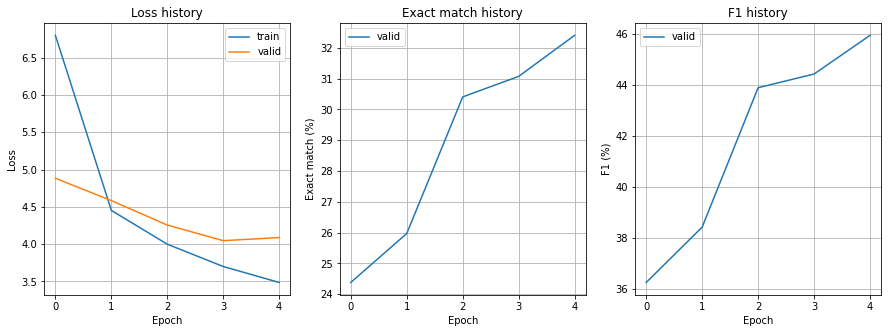

In [259]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history['em'], label='valid')
axes[1].set_title('Exact match history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Exact match (%)')
axes[1].grid(True)
axes[1].legend()

axes[2].plot(history['f1'], label='valid')
axes[2].set_title('F1 history')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 (%)')
axes[2].grid(True)
axes[2].legend()

plt.show()

***Inference***

In [290]:
drqa.load_state_dict(torch.load('./checkpoints/DrQA.pth'))
drqa.to(DEVICE)

DrQA(
  (dropout): Dropout(p=0.25, inplace=False)
  (embedding): Embedding(26885, 300, padding_idx=1318)
  (align_question_embedding_layer): AlignQuestionEmbeddingLayer(
    (linear): Linear(in_features=300, out_features=300, bias=True)
  )
  (ctx_stacked_bi_lstm_layer): StackedBiLSTMsLayer(
    (dropout): Dropout(p=0.25, inplace=False)
    (lstms): ModuleList(
      (0): LSTM(604, 256, num_layers=3, batch_first=True, bidirectional=True)
      (1): LSTM(512, 256, num_layers=3, batch_first=True, bidirectional=True)
      (2): LSTM(512, 256, num_layers=3, batch_first=True, bidirectional=True)
    )
  )
  (qst_encoding_layer): QuestionEncodingLayer(
    (stacked_bilstms_layer): StackedBiLSTMsLayer(
      (dropout): Dropout(p=0.25, inplace=False)
      (lstms): ModuleList(
        (0): LSTM(300, 256, num_layers=3, batch_first=True, bidirectional=True)
        (1): LSTM(512, 256, num_layers=3, batch_first=True, bidirectional=True)
        (2): LSTM(512, 256, num_layers=3, batch_first=True, 

In [320]:
def inference(model: nn.Module, context: spacy.tokens.doc.Doc, question: spacy.tokens.doc.Doc,
              text_vocab: Vocab, pos_vocab: Vocab, ner_vocab: Vocab, device: torch.device):
    # Build extra features
    question = [token.text.lower() for token in question]
    counts = collections.Counter(map(lambda token: token.text.lower(), context))
    freqs = {index: counts[token.text.lower()] for index, token in enumerate(context)}
    freqs_norm = sum(freqs.values())
    em, pos, ner, ntf = zip(
        *map(lambda index: [
            context[index].text.lower() in question, context[index].tag_,
            context[index].ent_type_ or 'None',
            freqs[index] / freqs_norm
        ], range(len(context)))
    )

    # Build tensors
    ctx = torch.LongTensor([*map(lambda word: text_vocab.stoi(word), context)]).unsqueeze(0).to(device)
    qst = torch.LongTensor([*map(lambda word: text_vocab.stoi(word), question)]).unsqueeze(0).to(device)
    len_ctx = torch.LongTensor([len(context)]).to(device)
    len_qst = torch.LongTensor([len(question)]).to(device)
    em = torch.LongTensor(em).unsqueeze(0).to(device)
    pos = torch.LongTensor([*map(lambda x: pos_vocab.stoi(x), pos)]).unsqueeze(0).to(device)
    ner = torch.LongTensor([*map(lambda x: ner_vocab.stoi(x), ner)]).unsqueeze(0).to(device)
    ntf = torch.LongTensor(ntf).unsqueeze(0).to(device)

    # Prediction
    model.eval()
    with torch.no_grad():
        # Feed the model
        start, end = model(ctx_sequences=ctx, ctx_lengths=len_ctx, qst_sequences=qst, qst_lengths=len_qst,
                           em_sequences=em, pos_sequences=pos, ner_sequences=ner, ntf_sequences=ntf)
    
        # Decode the result indexes
        start_index, end_index, proba = model.__class__.decode(starts=F.softmax(start, dim=-1), ends=F.softmax(end, dim=-1))

        # Extract the answer
        answer = context[start_index[0]:end_index[0] + 1]

    return answer, proba[0]

In [334]:
for index in np.random.choice(len(valid_qas), size=25, replace=False):
    id = valid_qas[index]['id']
    context = valid_qas[index]['context']
    question = valid_qas[index]['question']

    answers = []
    for qa in valid_qas:
        if id == qa['id']:
            answers.append(qa['answer'])

    prediction, proba = inference(model=drqa, context=context, question=question,
                                  text_vocab=TEXT, pos_vocab=POS, ner_vocab=NER, device=DEVICE)
    
    html = f'<p><span><b>Context:</b> {context.text}</span><br />'
    html += f'<span><b>Question:</b> {question.text}</span><br />'
    html += f'<span style="color:blue"><b>Answers:</b><br /><ul>'
    for answer in answers:
        html += f'<li style="color:blue">{answer.text}</li>'
    html += '</ul></span><br />'
    html += f'<span style="color:green"><b>Prediction:</b> {prediction}</span><br />'
    html += f'<span style="color:green"><b>Probability:</b> {proba * 100:.3f}%</span><br />'
    display(HTML(html))
    print('='*100)

('', [89.63230895996094])